# Visualize travel time to cities and ports in the year 2015 maps

This notebook shows how to read and visualize travel time to cities and ports maps. These maps represent a unique global representation of physical access to essential services offered by cities and ports. 

Each accessibility layer is a 30 arc-second resolution raster in WGS84 (coordinate reference system EPSG:4326) projection with a bounding box of 85°N, 180°E, 60°S and 180°W. The format is single band GeoTIFF, 16 bit unsigned integer with 65,535 as the nodata value. The pixel values represent the time in minutes from that pixel to the nearest settlement. Travel times are reported for all pixels classified as land or inland water areas.

The dataset is available at the figshare repository https://doi.org/10.6084/m9.figshare.7638134.v3
The dataset and the validation are fully described in a Nature Scientific Data Descriptor https://www.nature.com/articles/s41597-019-0265-5


## 1. Installing the required packages

Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/

In [43]:
!pip install matplotlib
!pip install pillow
!pip install numpy
!pip install opencv-python-headless

In [44]:
!conda install -c conda-forge gdal --yes

Solving environment: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c defaults conda





# All requested packages already installed.

Retrieving notices: ...working... done


## 2. Import required libraries

In [45]:
import requests
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
from osgeo import gdal

## 3. Set dataset id and base URL

In [46]:
id = '7638134'
api_url = "https://api.figshare.com/v2/"

## 4. Retrieve Dataset

In this section, change the minimum and maximum population to choose the travel time maps you would like to retrieve (select from the range in maps_dict)

In [47]:
maps_dict = {
        'Travel_time_to_cities_5000000_50000000': 'travel_time_to_cities_1.tif',
        'Travel_time_to_cities_1000000_5000000': 'travel_time_to_cities_2.tif',
        'Travel_time_to_cities_500000_1000000': 'travel_time_to_cities_3.tif',
        'Travel_time_to_cities_200000_500000': 'travel_time_to_cities_4.tif',
        'Travel_time_to_cities_100000_200000': 'travel_time_to_cities_5.tif',
        'Travel_time_to_cities_50000_100000': 'travel_time_to_cities_6.tif',    
        'Travel_time_to_cities_20000_50000': 'travel_time_to_cities_7.tif',
        'Travel_time_to_cities_10000_20000': 'travel_time_to_cities_8.tif',
        'Travel_time_to_cities_5000_10000': 'travel_time_to_cities_9.tif',
        }
# input minimum and maximum population (select from the maps_dict)
Min_Population = '5000'
Max_Population = '50000'

# select relevant maps
new_maps_dict ={}
for item in list(maps_dict.keys()):
        x = item.split('_')
        if int(Min_Population) <= int(x[4]) < int(Max_Population):
            new_maps_dict[item] = maps_dict[item]
maps_name = list(new_maps_dict.values())
print('the relevant travel time maps to the selected population are: ')
print(new_maps_dict)

the relevant travel time maps to the selected population are: 
{'Travel_time_to_cities_20000_50000': 'travel_time_to_cities_7.tif', 'Travel_time_to_cities_10000_20000': 'travel_time_to_cities_8.tif', 'Travel_time_to_cities_5000_10000': 'travel_time_to_cities_9.tif'}


In [48]:
# Define functions that read and download files
def read_public_article(id, api_url):
    request_url = f"{api_url}articles/{id}"
    print("Sending request to:", api_url)
    response = requests.get(request_url)
    status_code = response.status_code
    print(f"Response status: {status_code}")

    if status_code == 200:
        jsonResponse = response.json()
        return jsonResponse
    else:
        print("Error")
        return None

def download_file(folder, file_name, download_url):
    if os.path.exists(os.path.join(folder, file_name)):
        print(f"File {file_name} was already retrieved.")
        return
    print("Downloading ", file_name)
    response = requests.get(download_url)
    status_code = response.status_code
    if (status_code == 200):
        print(f"File {file_name} was retrieved successfully!")
        open(os.path.join(folder, file_name) , 'wb').write(response.content)
        print(f"File address: {os.path.join(folder, file_name)}")
    else:
        print(f"Could not donwload {file_name}.")
    

def download_article_files(folder, article_json):
       
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"{folder} directory was created!")

    for item in article_json['files']:
        for name in maps_name:       
            if item['name'] == name:
              download_file(folder, item['name'], item['download_url'])      
           
article_json = read_public_article(id=id, api_url=api_url)
# All the downloaded maps are saved next to this notebook in the folder 'data'. you can change the path for saving the maps in any location you would like.
download_article_files('data', article_json=article_json)

Sending request to: https://api.figshare.com/v2/
Response status: 200
File travel_time_to_cities_7.tif was already retrieved.
File travel_time_to_cities_8.tif was already retrieved.
File travel_time_to_cities_9.tif was already retrieved.


## 5. Create a subset of maps

Each travel map is a 30 arc-second resolution raster in WGS84 (coordinate reference system EPSG:4326) projection with a bounding box of 85°N, 180°E, 60°S and 180°W. In this section you can crop retrieved maps using a bounding box. 

In [49]:

Image.MAX_IMAGE_PIXELS = None
# change the following coordinates to any bounding box you want (select inside the bounding box of 85°N, 180°E, 60°S and 180°W) 
upper_left_x = 110
upper_left_y = -10
lower_right_x = 155
lower_right_y = -42
window = (upper_left_x,upper_left_y,lower_right_x,lower_right_y)
crop_maps_dict = {}
for item in list(new_maps_dict.keys()):
    file_name = gdal.OpenEx(os.path.join('data',new_maps_dict[item]))
    # the croped maps are saved next to the downloaded maps(folder 'data'). you can change the path for saving the croped map in any location you would like. 
    crop_maps_dict ['crop_'+ item] = 'crop_' + new_maps_dict[item]
    gdal.Translate(os.path.join('data',crop_maps_dict['crop_'+ item]), file_name, projWin = window)
print('the croped travel time maps are: ')
print(crop_maps_dict)

the croped travel time maps are: 
{'crop_Travel_time_to_cities_20000_50000': 'crop_travel_time_to_cities_7.tif', 'crop_Travel_time_to_cities_10000_20000': 'crop_travel_time_to_cities_8.tif', 'crop_Travel_time_to_cities_5000_10000': 'crop_travel_time_to_cities_9.tif'}


### 5.1 show the subset travel time map

Text(0.5, 1.0, 'crop_Travel_time_to_cities_5000_10000')

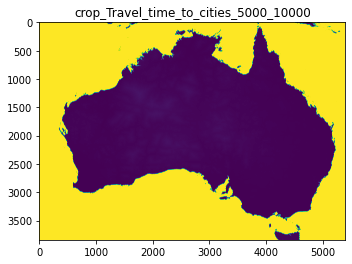

In [50]:
# change the name of croped travel time map to what you desirewant to visualize (select from the above crop_maps_dict list)
map = 'crop_Travel_time_to_cities_5000_10000'
plt.figure(1)
plt.imshow(Image.open(os.path.join('data',crop_maps_dict[map])))
plt.title(map)

## 6. Combination of different travel time maps

Nine layers represent travel times to human settlements of different population ranges. Two or more layers can be combined into one layer by recording the minimum pixel value across the layers.For example, a map of travel time to the nearest settlement of 5,000 to 50,000 people could be generated by taking the minimum of the three layers that represent the travel time to settlements with populations between 5,000 and 10,000, 10,000 and 20,000 and, 20,000 and 50,000 people.
In this section, change the minimum and maximum population you would like to create a new travel time map.

In [51]:
# input minimum and maximum population (choose between minimum and maximum you chose for retrieving maps in section 4)
Min_Population = '5000'
Max_Population = '20000'

Image.MAX_IMAGE_PIXELS = None
# define function to get the geoinformation of the maps
def get_geoinfo(folder, file_name):
    sourceds = Image.open(os.path.join(folder,file_name))
    dataset1 = gdal.Open(os.path.join(folder,file_name))
    projection = dataset1.GetProjection()
    geotransform = dataset1.GetGeoTransform()
    width, height = sourceds.size
    return width, height, projection, geotransform

# define function to get the minimum of the travel time between the selected maps
def find_min_travel_time_map(Min_Population, Max_Population, crop_maps_dict):

    # select relevant maps
    combined_maps_dict ={}
    for item in list(crop_maps_dict.keys()):
        x = item.split('_')
        if int(Min_Population) <= int(x[5]) < int(Max_Population):
            combined_maps_dict[item] = crop_maps_dict[item]             
    combined_maps_name = list(combined_maps_dict.values())

    # get the geoinformation of a map
    width, height, projection, geotransform = get_geoinfo('data', file_name = combined_maps_name[0])
    
    # read relevant maps and creat a list of them
    combined_maps_list = np.zeros((height,width,1,len(combined_maps_name)), np.uint16)
    for i in range(len(combined_maps_name)):
      img = gdal.Open(os.path.join('data',combined_maps_name[i]))
      band = img.GetRasterBand(1)
      combined_maps_list[:,:,0, i] = band.ReadAsArray()
      
    # define a path to save the new travel time map in folder 'data'
    combined_travel_time_map_path = r'data\combined_travel_time_map.tif'

    # create the new travle time map
    combined_travel_time_map = combined_maps_list.min(axis=3)
    cv2.imwrite(combined_travel_time_map_path ,combined_travel_time_map)

    # set the projection and geotransform 
    dataset2 = gdal.Open(combined_travel_time_map_path, gdal.GA_Update)
    dataset2.SetGeoTransform( geotransform )
    dataset2.SetProjection( projection )
    return combined_travel_time_map, combined_maps_dict, combined_maps_list

combined_travel_time_map, combined_maps_dict, combined_maps_list = find_min_travel_time_map (Min_Population, Max_Population, crop_maps_dict)
print('layers that represent the travel time to settlements with populations between ' + Min_Population + ' and ' + Max_Population +  ' are: ')
print(combined_maps_dict)


layers that represent the travel time to settlements with populations between 5000 and 20000 are: 
{'crop_Travel_time_to_cities_10000_20000': 'crop_travel_time_to_cities_8.tif', 'crop_Travel_time_to_cities_5000_10000': 'crop_travel_time_to_cities_9.tif'}


### 6.1 show the new travel time map

Text(0.5, 1.0, 'crop_Travel_time_to_cities_5000_20000')

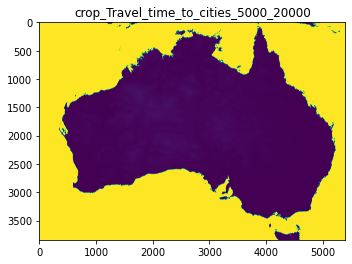

In [52]:
plt.figure(1)
plt.imshow(combined_travel_time_map)
plt.title('crop_Travel_time_to_cities_' + Min_Population + '_' + Max_Population)